# Deep Dive into Comparative Analysis between Apriori and Frequent Pattern (Fp) Growth algorithms and Brief comparison with RARM, ECLAT and ASPMS   
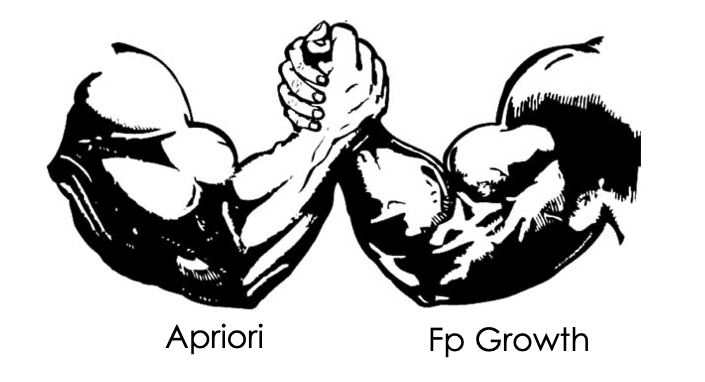   


This kernel is a comprehensive overview focused on the comparative analysis between Apriori and Frequent Pattern Growth algorithms. In the end, we will have a look at the comparative table between additional algorithms such as: **RAMS, ECLAT, ASPMS.**  These are all association rule algorithms.  
[I wrote this first kernel](https://www.kaggle.com/keitazoumana/a-simple-way-to-understand-association-rule) to give you more information about how an association rule works.   
We will be covering the following topics:   

## Data Preparation for association rules   
## Association Rules implementation   
## Comparative Analyzis 

### Useful Libraries

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth

In [2]:
# Load the dataset
groceries = pd.read_csv("../input/groceries-dataset/Groceries_dataset.csv")

In [3]:
groceries.shape

(38765, 3)

In [4]:
groceries.head()

Member_number        Date   itemDescription
0           1808  21-07-2015    tropical fruit
1           2552  05-01-2015        whole milk
2           2300  19-09-2015         pip fruit
3           1187  12-12-2015  other vegetables
4           3037  01-02-2015        whole milk

In [5]:
# Get all the transactions as a list of lists
all_transactions = [transaction[1]['itemDescription'].tolist() for transaction in list(groceries.groupby(['Member_number', 'Date']))]

In [6]:
# First 21st transactions in the transactional dataset
len(all_transactions)

14963

# Data Preparation

We need to transform the data into the following format, which is suitable to perform our association rules.  
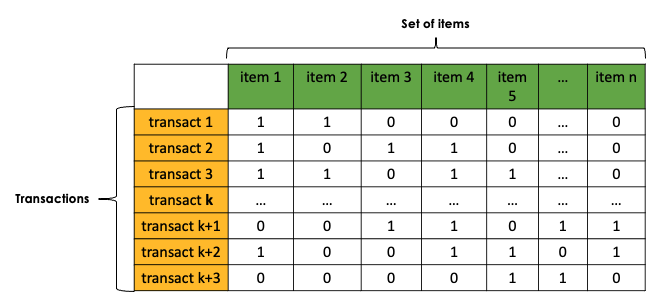

In [7]:
# Look at the 10 first transactions
all_transactions[0:10]

[['sausage', 'whole milk', 'semi-finished bread', 'yogurt'],
 ['whole milk', 'pastry', 'salty snack'],
 ['canned beer', 'misc. beverages'],
 ['sausage', 'hygiene articles'],
 ['soda', 'pickled vegetables'],
 ['frankfurter', 'curd'],
 ['sausage', 'whole milk', 'rolls/buns'],
 ['whole milk', 'soda'],
 ['beef', 'white bread'],
 ['frankfurter', 'soda', 'whipped/sour cream']]

The Ones and Zeros in the matrix are boolean values, they could also be respectively replaced by True and False, where: 
* **True** means that the item exists in the transaction   
* **False** means it does not  

In [8]:
# The following instructions transform the dataset into the required format 
trans_encoder = TransactionEncoder() # Instanciate the encoder
trans_encoder_matrix = trans_encoder.fit(all_transactions).transform(all_transactions)
trans_encoder_matrix = pd.DataFrame(trans_encoder_matrix, columns=trans_encoder.columns_)

In [9]:
trans_encoder_matrix.head()

Instant food products  UHT-milk  abrasive cleaner  artif. sweetener  \
0                  False     False             False             False   
1                  False     False             False             False   
2                  False     False             False             False   
3                  False     False             False             False   
4                  False     False             False             False   

   baby cosmetics   bags  baking powder  bathroom cleaner   beef  berries  \
0           False  False          False             False  False    False   
1           False  False          False             False  False    False   
2           False  False          False             False  False    False   
3           False  False          False             False  False    False   
4           False  False          False             False  False    False   

   ...  turkey  vinegar  waffles  whipped/sour cream  whisky  white bread  \
0  ...   False    False    False               False   False        False   
1  ...   False    False    False               False   False        False   
2  ...   False    False    False               False   False        False   
3  ...   False    False    False               False   False        False   
4  ...   False    False    False               False   False        False   

   white wine  whole milk  yogurt  zwieback  
0       False        True    True     False  
1       False        True   False     False  
2       False       False   False     False  
3       False       False   False     False  
4       False       False   False     False  

[5 rows x 167 columns]

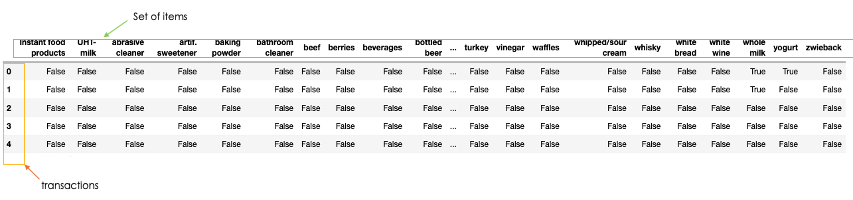

# Association Rules Implementation

* **support** tells how popular an item is based on the proportion of all transactions that are included. The popularity is met if it corresponds to the user-specified support thresold. For instance, a support threshold set to 0.2 (20%) means that the user wants all the items that occur together in at least 20% of all transactions.  
* A High support thresold does not give much more item combination, so reducing the value might be helpful to see much more item combinations for marketing purpose.

### Helper Functions

In [10]:
def perform_rule_calculation(transact_items_matrix, rule_type="fpgrowth", min_support=0.001):
    """
    desc: this function performs the association rule calculation 
    @params:
        - transact_items_matrix: the transaction X Items matrix
        - rule_type: 
                    - apriori or Growth algorithms (default="fpgrowth")
                    
        - min_support: minimum support threshold value (default = 0.001)
        
    @returns:
        - the matrix containing 3 columns:
            - support: support values for each combination of items
            - itemsets: the combination of items
            - number_of_items: the number of items in each combination of items
            
        - the excution time for the corresponding algorithm
        
    """
    start_time = 0
    total_execution = 0
    
    if(not rule_type=="fpgrowth"):
        start_time = time.time()
        rule_items = apriori(transact_items_matrix, 
                       min_support=min_support, 
                       use_colnames=True)
        total_execution = time.time() - start_time
        print("Computed Apriori!")
        
    else:
        start_time = time.time()
        rule_items = fpgrowth(transact_items_matrix, 
                       min_support=min_support, 
                       use_colnames=True)
        total_execution = time.time() - start_time
        print("Computed Fp Growth!")
    
    rule_items['number_of_items'] = rule_items['itemsets'].apply(lambda x: len(x))
    
    return rule_items, total_execution


In [11]:
def compute_association_rule(rule_matrix, metric="lift", min_thresh=1):
    """
    @desc: Compute the final association rule
    @params:
        - rule_matrix: the corresponding algorithms matrix
        - metric: the metric to be used (default is lift)
        - min_thresh: the minimum threshold (default is 1)
        
    @returns:
        - rules: all the information for each transaction satisfying the given metric & threshold
    """
    rules = association_rules(rule_matrix, 
                              metric=metric, 
                              min_threshold=min_thresh)
    
    return rules

In [12]:
# Plot Lift Vs Coverage(confidence) 
def plot_metrics_relationship(rule_matrix, col1, col2):
    """
    desc: shows the relationship between the two input columns 
    @params:
        - rule_matrix: the matrix containing the result of a rule (apriori or Fp Growth)
        - col1: first column
        - col2: second column
    """
    fit = np.polyfit(rule_matrix[col1], rule_matrix[col2], 1)
    fit_funt = np.poly1d(fit)
    plt.plot(rule_matrix[col1], rule_matrix[col2], 'yo', rule_matrix[col1], 
    fit_funt(rule_matrix[col1]))
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.title('{} vs {}'.format(col1, col2))

In [13]:
def compare_time_exec(algo1=list, alg2=list):
    """
    @desc: shows the execution time between two algorithms
    @params:
        - algo1: list containing the description of first algorithm, where
            
        - algo2: list containing the description of second algorithm, where
    """
    
    execution_times = [algo1[1], algo2[1]]
    algo_names = (algo1[0], algo2[0])
    y=np.arange(len(algo_names))
    
    plt.bar(y,execution_times,color=['orange', 'blue'])
    plt.xticks(y,algo_names)
    plt.xlabel('Algorithms')
    plt.ylabel('Time')
    plt.title("Execution Time (seconds) Comparison")
    plt.show()

In [14]:
val = {'name':12}
value = list(val.items())[0]

In [15]:
value

('name', 12)

## Case nÂ°1: Using Fp Growph Algorithm

In [16]:
fpgrowth_matrix, fp_growth_exec_time = perform_rule_calculation(trans_encoder_matrix) # Run the algorithm
print("Fp Growth execution took: {} seconds".format(fp_growth_exec_time))

Computed Fp Growth!
Fp Growth execution took: 0.15892648696899414 seconds


In [17]:
fpgrowth_matrix.head()

support               itemsets  number_of_items
0  0.157923           (whole milk)                1
1  0.085879               (yogurt)                1
2  0.060349              (sausage)                1
3  0.009490  (semi-finished bread)                1
4  0.051728               (pastry)                1

In [18]:
fpgrowth_matrix.tail()

support                         itemsets  number_of_items
745  0.001403            (chewing gum, yogurt)                2
746  0.001069  (other vegetables, chewing gum)                2
747  0.001002              (chewing gum, soda)                2
748  0.001069              (pasta, whole milk)                2
749  0.001002  (seasonal products, rolls/buns)                2

### Lift 

In [19]:
fp_growth_rule_lift = compute_association_rule(fpgrowth_matrix)

In [20]:
fp_growth_rule_lift.head()

antecedents               consequents  antecedent support  \
0      (whole milk, yogurt)              (rolls/buns)            0.011161   
1  (whole milk, rolls/buns)                  (yogurt)            0.013968   
2      (yogurt, rolls/buns)              (whole milk)            0.007819   
3              (whole milk)      (yogurt, rolls/buns)            0.157923   
4                  (yogurt)  (whole milk, rolls/buns)            0.085879   

   consequent support   support  confidence      lift  leverage  conviction  
0            0.110005  0.001337    0.119760  1.088685  0.000109    1.011083  
1            0.085879  0.001337    0.095694  1.114293  0.000137    1.010854  
2            0.157923  0.001337    0.170940  1.082428  0.000102    1.015701  
3            0.007819  0.001337    0.008464  1.082428  0.000102    1.000650  
4            0.013968  0.001337    0.015564  1.114293  0.000137    1.001622

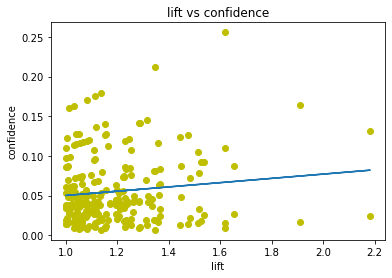

In [21]:
plot_metrics_relationship(fp_growth_rule_lift, col1='lift', col2='confidence')

### Confidence

In [22]:
fp_growth_rule = compute_association_rule(fpgrowth_matrix, metric="confidence", min_thresh=0.2)
fp_growth_rule.head()

antecedents   consequents  antecedent support  \
0      (yogurt, sausage)  (whole milk)            0.005748   
1  (sausage, rolls/buns)  (whole milk)            0.005347   

   consequent support   support  confidence      lift  leverage  conviction  
0            0.157923  0.001470    0.255814  1.619866  0.000563    1.131541  
1            0.157923  0.001136    0.212500  1.345594  0.000292    1.069304

## Case nÂ°2: Using Apriori Algorithm

In [23]:
apriori_matrix, apriori_exec_time = perform_rule_calculation(trans_encoder_matrix, rule_type="apriori")
print("Apriori Execution took: {} seconds".format(apriori_exec_time))

Computed Apriori!
Apriori Execution took: 3.176582098007202 seconds


In [24]:
apriori_matrix.head()

support                 itemsets  number_of_items
0  0.004010  (Instant food products)                1
1  0.021386               (UHT-milk)                1
2  0.001470       (abrasive cleaner)                1
3  0.001938       (artif. sweetener)                1
4  0.008087          (baking powder)                1

In [25]:
apriori_matrix.tail()

support                           itemsets  number_of_items
745  0.001136  (whole milk, sausage, rolls/buns)                3
746  0.001002     (soda, whole milk, rolls/buns)                3
747  0.001337   (whole milk, yogurt, rolls/buns)                3
748  0.001069        (whole milk, sausage, soda)                3
749  0.001470      (whole milk, sausage, yogurt)                3

### Lift  

In [26]:
apriori_rule_lift = compute_association_rule(apriori_matrix)

In [27]:
apriori_rule_lift.head()

antecedents       consequents  antecedent support  consequent support  \
0        (UHT-milk)  (tropical fruit)            0.021386            0.067767   
1  (tropical fruit)        (UHT-milk)            0.067767            0.021386   
2     (brown bread)            (beef)            0.037626            0.033950   
3            (beef)     (brown bread)            0.033950            0.037626   
4    (citrus fruit)            (beef)            0.053131            0.033950   

    support  confidence      lift      leverage  conviction  
0  0.001537    0.071875  1.060617  8.785064e-05    1.004426  
1  0.001537    0.022682  1.060617  8.785064e-05    1.001326  
2  0.001537    0.040853  1.203301  2.597018e-04    1.007196  
3  0.001537    0.045276  1.203301  2.597018e-04    1.008012  
4  0.001804    0.033962  1.000349  6.297697e-07    1.000012

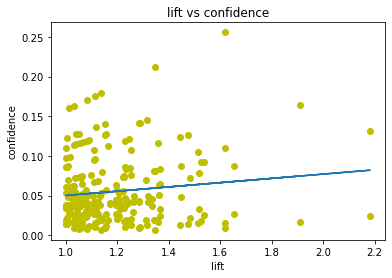

In [28]:
plot_metrics_relationship(apriori_rule_lift, col1='lift', col2='confidence')

### Confidence

In [29]:
apripri_rule = compute_association_rule(apriori_matrix, metric="confidence", min_thresh=0.2)
apripri_rule.head()

antecedents   consequents  antecedent support  \
0  (sausage, rolls/buns)  (whole milk)            0.005347   
1      (yogurt, sausage)  (whole milk)            0.005748   

   consequent support   support  confidence      lift  leverage  conviction  
0            0.157923  0.001136    0.212500  1.345594  0.000292    1.069304  
1            0.157923  0.001470    0.255814  1.619866  0.000563    1.131541

# Comparative Analyzis

Next Time: Another technic such as ASPMS will be included in the comparative analysis phases.   
https://core.ac.uk/download/pdf/82306393.pdf

Based on the previous experiences, we can perform the following analyzis    
## Time execution    

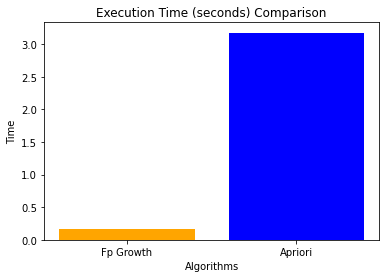

In [30]:
algo1 = ['Fp Growth', fp_growth_exec_time]
algo2 = ['Apriori', apriori_exec_time]

compare_time_exec(algo1, algo2)

# Conclusion     

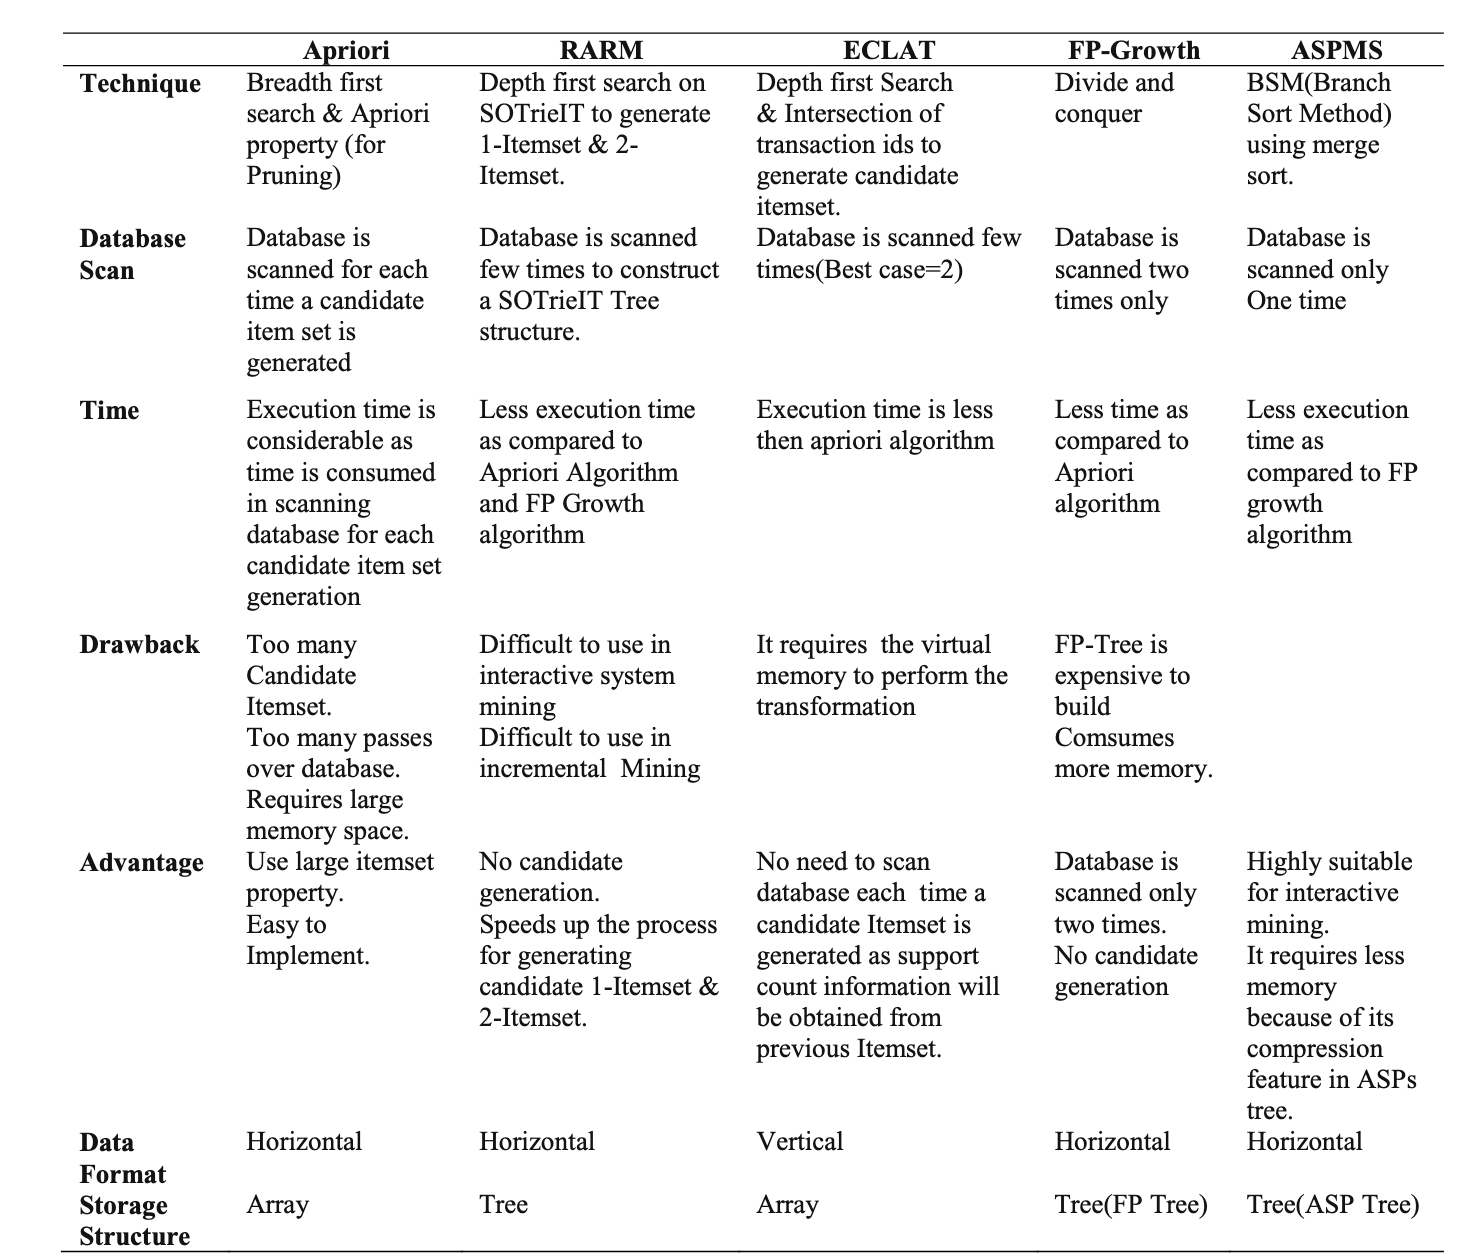

I hope you enjoyed your journey through this kernel ðŸ˜€! Feel free to give it an upvote   
If you have any question or remark, I will be glad to welcome it for further discussions      

For further readings do not hesitate to consult the following links:

# Sources   
https://www.researchgate.net/publication/272864559_Comparing_the_Performance_of_Frequent_Pattern_Mining_Algorithms   
http://www.lastnightstudy.com/Show?id=123/Difference-Between-Fp-growth-and-Apriori-Algorithm    
https://core.ac.uk/download/pdf/82306393.pdf